In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
!pip install roboflow

from roboflow import Roboflow
rf = Roboflow(api_key="baZbg4YRiN1PBEMao7aY")
project = rf.workspace("smartathon").project("new-pothole-detection")
version = project.version(2)
dataset = version.download("yolo26")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.0/94.0 kB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.9/49.9 MB 41.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 66.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 111.8 MB/s eta 0:00:00
  Attempting uninstall: opencv-python-headless
    Found existing installation: opencv-python-headless 4.12.0.88
    Uninstalling opencv-python-headless-4.12.0.88:
      Successfully uninstalled opencv-python-headless-4.12.0.88
  Attempting uninstall: idna
    Found existing installation: idna 3.11
    Uninstalling idna-3.11:
      Successfully uninstalled idna-3.11
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-adk 1.22.1 requires google-cloud-bigquery-storage>=2.0.0, w


Extracting Dataset Version Zip to New-pothole-detection-2 in yolo26:: 100%|██████████| 18492/18492 [00:02<00:00, 7844.55it/s]


In [3]:
import tensorflow as tf
print(f"TensorFlow vesrion: {tf.__version__}")

## Add timestamp
import datetime
print(f"Notebook last run (end-to-end): {datetime.datetime.now()}")

2026-02-19 12:03:48.931889: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1771502629.175891      24 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1771502629.245321      24 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1771502629.770000      24 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1771502629.770034      24 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1771502629.770036      24 computation_placer.cc:177] computation placer alr

TensorFlow vesrion: 2.19.0
Notebook last run (end-to-end): 2026-02-19 12:04:03.311625


In [4]:
dir(dataset)


['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 'location',
 'model_format',
 'name',
 'version']

Loaded classes: ['Pothole']


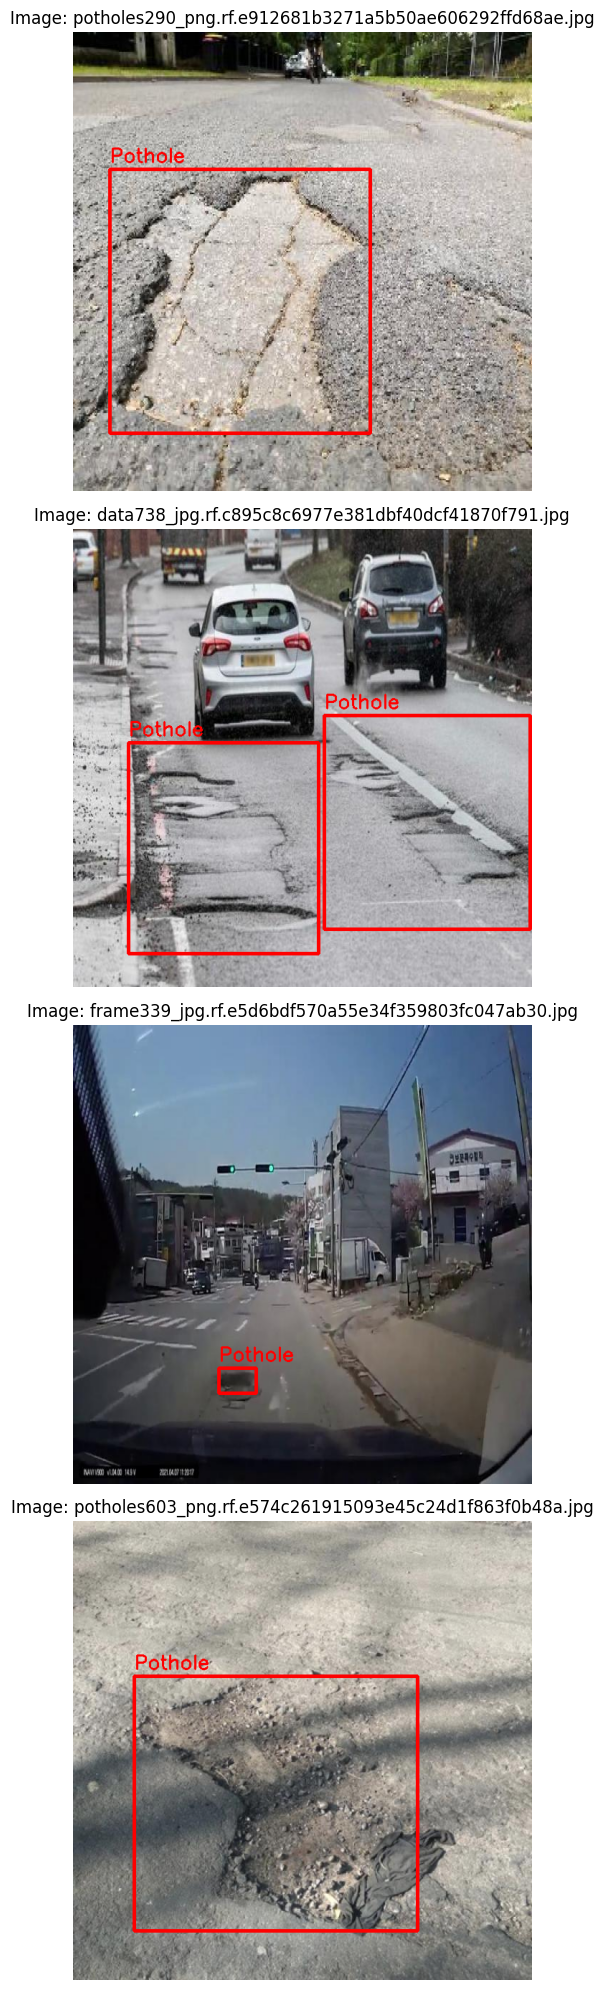

In [5]:
import os
import random
import cv2
import yaml
import matplotlib.pyplot as plt
import glob

# 1. SETUP PATHS
# Based on your screenshot, this is the root directory
base_dir = '/kaggle/working/New-pothole-detection-2'
train_img_dir = os.path.join(base_dir, 'train', 'images')
train_label_dir = os.path.join(base_dir, 'train', 'labels')
yaml_path = os.path.join(base_dir, 'data.yaml')

# 2. LOAD CLASS NAMES
# We read the yaml file to know what "Class 0" or "Class 1" actually is (e.g., "Pothole")
class_names = []
try:
    with open(yaml_path, 'r') as f:
        data = yaml.safe_load(f)
        class_names = data.get('names', [])
        print(f"Loaded classes: {class_names}")
except Exception as e:
    print(f" Could not load data.yaml: {e}")
    # Fallback if yaml fails
    class_names = ['0', '1', '2', '3', '4'] 

# 3. VISUALIZATION FUNCTION
def plot_random_samples(num_samples=3):
    # Get list of all images
    image_files = glob.glob(os.path.join(train_img_dir, '*.jpg')) + \
                  glob.glob(os.path.join(train_img_dir, '*.png'))
    
    if not image_files:
        print("No images found. Check if 'train/images' folder exists inside your dataset.")
        return

    # Select random images
    random_images = random.sample(image_files, min(num_samples, len(image_files)))

    plt.figure(figsize=(15, 5 * num_samples))

    for idx, img_path in enumerate(random_images):
        # Load Image
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        h, w, _ = img.shape

        # Construct Label Path
        # Replaces /images/ with /labels/ and .jpg with .txt
        label_path = img_path.replace('images', 'labels').replace('.jpg', '.txt').replace('.png', '.txt')

        if os.path.exists(label_path):
            with open(label_path, 'r') as f:
                lines = f.readlines()

            for line in lines:
                parts = line.strip().split()
                class_id = int(parts[0])
                
                # YOLO Format: x_center, y_center, width, height (normalized 0-1)
                x_center, y_center, box_w, box_h = map(float, parts[1:])

                # Convert to Pixel Coordinates
                x1 = int((x_center - box_w / 2) * w)
                y1 = int((y_center - box_h / 2) * h)
                x2 = int((x_center + box_w / 2) * w)
                y2 = int((y_center + box_h / 2) * h)

                # Draw Rectangle
                cv2.rectangle(img, (x1, y1), (x2, y2), (255, 0, 0), 3)
                
                # Add Label Text
                label_text = class_names[class_id] if class_id < len(class_names) else str(class_id)
                cv2.putText(img, label_text, (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (255, 0, 0), 2)
        else:
            print(f"Label file not found for {os.path.basename(img_path)}")

        # Plotting
        plt.subplot(num_samples, 1, idx + 1)
        plt.imshow(img)
        plt.axis('off')
        plt.title(f"Image: {os.path.basename(img_path)}")

    plt.tight_layout()
    plt.show()

# 4. RUN THE VISUALIZER
plot_random_samples(num_samples=4)

In [6]:
!pip install ultralytics -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 21.9 MB/s eta 0:00:00


In [7]:
import yaml
import os

yaml_file_path = '/kaggle/working/New-pothole-detection-2/data.yaml'
base_dir = '/kaggle/working/New-pothole-detection-2'

# 3. Read the existing YAML
with open(yaml_file_path, 'r') as f:
    data = yaml.safe_load(f)
data['path'] = base_dir
data['train'] = 'train/images'
data['val'] = 'valid/images'
data['test'] = 'test/images'
with open(yaml_file_path, 'w') as f:
    yaml.dump(data, f)

print(f"Successfully updated paths in {yaml_file_path}")

Successfully updated paths in /kaggle/working/New-pothole-detection-2/data.yaml


from ultralytics import YOLO

model = YOLO('yolo26n.pt') 

results = model.train(
    data='/kaggle/working/New-pothole-detection-2/data.yaml',
    epochs=50,
    imgsz=480,
    batch=16,
    name='yolo_pothole',
    project='/kaggle/working/runs',
    exist_ok=True
)

In [8]:
from ultralytics import YOLO

model = YOLO('yolo26n.pt') 
results = model.train(
    data='/kaggle/working/New-pothole-detection-2/data.yaml',
    epochs=100,
    imgsz=320,
    batch=16,
    name='yolo_pothole_01',
    project='/kaggle/working/runs',
    exist_ok=True,
)

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
Ultralytics 8.4.14 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 14913MiB)
engine/trainer: agnostic_nms=False, amp=True, angle=1.0, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/kaggle/working/New-pothole-detection-2/data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, end2end=None, epochs=100, erasing=0.4, exist_ok=True, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v

In [9]:
from ultralytics import YOLO

best_model_path = '/kaggle/working/runs/yolo_pothole_01/weights/best.pt'
model = YOLO(best_model_path)

metrics = model.val(
    data='/kaggle/working/New-pothole-detection-2/data.yaml',
    split='test'
)

print("-" * 30)
print(f"Test mAP50:    {metrics.box.map50:.3f}")
print(f"Test Precision: {metrics.box.mp:.3f}")
print(f"Test Recall:    {metrics.box.mr:.3f}")
print("-" * 30)

Ultralytics 8.4.14 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 14913MiB)
YOLO26n summary (fused): 122 layers, 2,375,031 parameters, 0 gradients, 5.2 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1010.1±185.6 MB/s, size: 43.3 KB)
val: Scanning /kaggle/working/New-pothole-detection-2/test/labels... 1055 images, 1 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 1055/1055 1.6Kit/s 0.7s
val: New cache created: /kaggle/working/New-pothole-detection-2/test/labels.cache
WARNING ⚠️ Box and segment counts should be equal, but got len(segments) = 8, len(boxes) = 2653. To resolve this only boxes will be used and all segments will be removed. To avoid this please supply either a detect or segment dataset, not a detect-segment mixed dataset.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 66/66 13.5it/s 4.9s
                   all       1055       2653      0.786      0.714      0.761       0.46
Speed: 0.3ms preprocess, 1.6ms 


image 1/1 /kaggle/working/New-pothole-detection-2/test/images/GRMN5594-29_jpeg_jpg.rf.ae224385a04c8f90cf77b3c3aa54f210.jpg: 320x320 (no detections), 13.1ms
Speed: 1.2ms preprocess, 13.1ms inference, 0.4ms postprocess per image at shape (1, 3, 320, 320)

image 1/1 /kaggle/working/New-pothole-detection-2/test/images/potholes106_png_jpg.rf.a565199483f92a7c36dceb2e632a8e50.jpg: 320x320 1 Pothole, 11.4ms
Speed: 0.9ms preprocess, 11.4ms inference, 0.7ms postprocess per image at shape (1, 3, 320, 320)

image 1/1 /kaggle/working/New-pothole-detection-2/test/images/108_jpg.rf.714ccef95f6085c88c8125fac3d1034d.jpg: 320x320 3 Potholes, 11.7ms
Speed: 1.0ms preprocess, 11.7ms inference, 0.5ms postprocess per image at shape (1, 3, 320, 320)


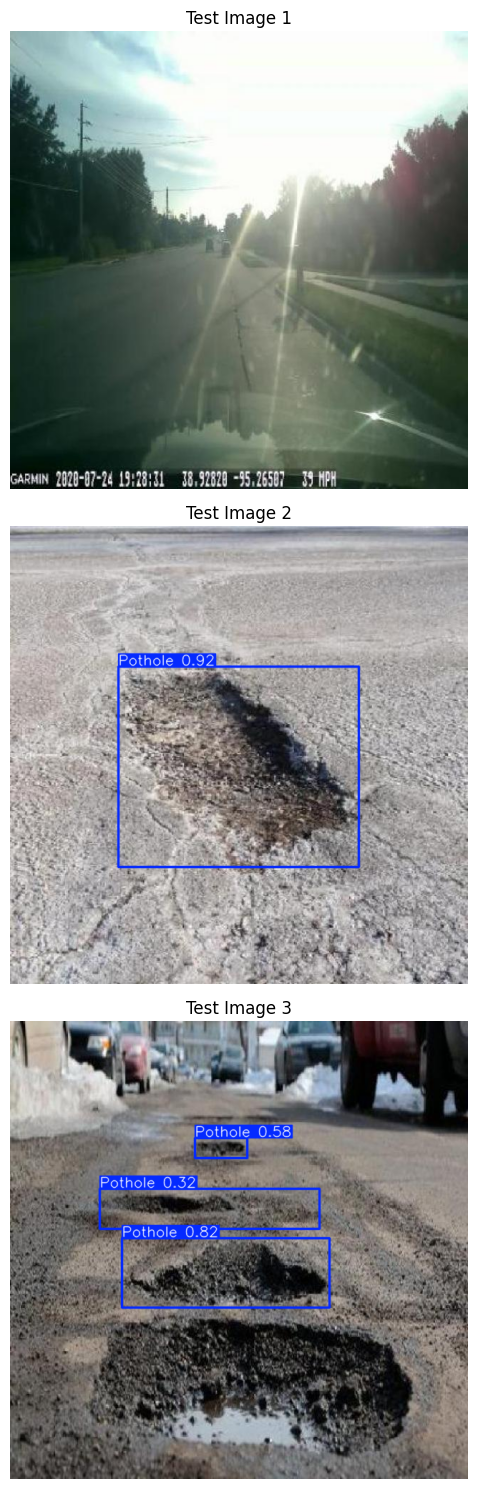

In [10]:
import os
import random
import cv2
import matplotlib.pyplot as plt
from ultralytics import YOLO

model = YOLO('/kaggle/working/runs/yolo_pothole_01/weights/best.pt')

test_images_path = '/kaggle/working/New-pothole-detection-2/test/images'

image_files = [os.path.join(test_images_path, f) for f in os.listdir(test_images_path) if f.endswith(('.jpg', '.png'))]
random_images = random.sample(image_files, 3)

plt.figure(figsize=(15, 15))

for i, img_path in enumerate(random_images):
    results = model(img_path)
    
    res_plotted = results[0].plot()
    
    res_plotted = cv2.cvtColor(res_plotted, cv2.COLOR_BGR2RGB)
    
    plt.subplot(3, 1, i + 1)
    plt.imshow(res_plotted)
    plt.axis('off')
    plt.title(f"Test Image {i+1}")

plt.tight_layout()
plt.show()

In [11]:
import cv2
import matplotlib.pyplot as plt
import os

matrix_path = '/kaggle/working/runs/yolo_mega_pothole_01/confusion_matrix_normalized.png'

if os.path.exists(matrix_path):
    img = cv2.imread(matrix_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    plt.figure(figsize=(10, 10))
    plt.imshow(img)
    plt.axis('off')
    plt.title("Normalized Confusion Matrix")
    plt.show()
else:
    print(f"❌ Could not find matrix at: {matrix_path}")
    print("Trying non-normalized version...")
    
    # Try non-normalized if normalized doesn't exist
    matrix_path = matrix_path.replace('_normalized', '')
    if os.path.exists(matrix_path):
        img = cv2.imread(matrix_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        plt.figure(figsize=(10, 10))
        plt.imshow(img)
        plt.axis('off')
        plt.show()

❌ Could not find matrix at: /kaggle/working/runs/yolo_mega_pothole_01/confusion_matrix_normalized.png
Trying non-normalized version...


In [12]:
from ultralytics import YOLO
from IPython.display import FileLink
import os
import time

model_path = '/kaggle/working/runs/yolo_pothole_01/weights/best.pt'
data_yaml = '/kaggle/working/New-pothole-detection-2/data.yaml'

print("Starting INT8 Export process...")
model = YOLO(model_path)

start_time = time.time()

try:
    exported_path = model.export(
        format='tflite', 
        int8=True, 
        data=data_yaml,
        imgsz=320,
        optimize=True,
        verbose=False
    )
    
    end_time = time.time()
    print(f"\nExport finished in {(end_time - start_time)/60:.1f} minutes.")
    
    if os.path.isdir(exported_path):
        for root, dirs, files in os.walk(exported_path):
            for file in files:
                if file.endswith('.tflite'):
                    print(f"File: {file}")
                    display(FileLink(os.path.join(root, file)))
    else:
        print(f"File: {os.path.basename(exported_path)}")
        display(FileLink(exported_path))

except Exception as e:
    print(f"\nError during export: {e}")

Starting INT8 Export process...
Ultralytics 8.4.14 🚀 Python-3.12.12 torch-2.8.0+cu126 CPU (Intel Xeon CPU @ 2.00GHz)
💡 ProTip: Export to OpenVINO format for best performance on Intel hardware. Learn more at https://docs.ultralytics.com/integrations/openvino/
YOLO26n summary (fused): 122 layers, 2,375,031 parameters, 0 gradients, 5.2 GFLOPs

PyTorch: starting from '/kaggle/working/runs/yolo_pothole_01/weights/best.pt' with input shape (1, 3, 320, 320) BCHW and output shape(s) (1, 300, 6) (5.1 MB)
requirements: Ultralytics requirements ['sng4onnx>=1.0.1', 'onnx_graphsurgeon>=0.3.26', 'ai-edge-litert>=1.2.0', 'onnx2tf>=1.26.3,<1.29.0', 'onnxslim>=0.1.71', 'onnxruntime-gpu'] not found, attempting AutoUpdate...
Using Python 3.12.12 environment at: /usr
Resolved 18 packages in 1.74s
Prepared 7 packages in 2.82s
Installed 7 packages in 13ms
 + ai-edge-litert==2.1.2
 + backports-strenum==1.3.1
 + onnx-graphsurgeon==0.5.8
 + onnx2tf==1.28.8
 + onnxruntime-gpu==1.24.1
 + onnxslim==0.1.85
 + sng4

Exporting to ONNX opset version 22 is not supported. by 'torch.onnx.export()'. The highest opset version supported is 20. To use a newer opset version, consider 'torch.onnx.export(..., dynamo=True)'. 
Exporting aten::index operator of advanced indexing in opset 22 is achieved by combination of multiple ONNX operators, including Reshape, Transpose, Concat, and Gather. If indices include negative values, the exported graph will produce incorrect results.


ONNX: slimming with onnxslim 0.1.85...
ONNX: export success ✅ 2.0s, saved as '/kaggle/working/runs/yolo_pothole_01/weights/best.onnx' (9.3 MB)
Unzipping calibration_image_sample_data_20x128x128x3_float32.npy.zip to /kaggle/working/calibration_image_sample_data_20x128x128x3_float32.npy...: 100% ━━━━━━━━━━━━ 1/1 47.7files/s 0.0s
TensorFlow SavedModel: starting TFLite export with onnx2tf 1.28.8...


I0000 00:00:1771508622.796014      24 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 12885 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1771508622.801297      24 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13755 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5
I0000 00:00:1771508626.719759      24 cuda_dnn.cc:529] Loaded cuDNN version 91002


Saved artifact at '/kaggle/working/runs/yolo_pothole_01/weights/best_saved_model'. The following endpoints are available:

* Endpoint 'serving_default'
  inputs_0 (POSITIONAL_ONLY): TensorSpec(shape=(1, 320, 320, 3), dtype=tf.float32, name='images')
Output Type:
  TensorSpec(shape=(1, 300, 6), dtype=tf.float32, name=None)
Captures:
  137993053057680: TensorSpec(shape=(4, 2), dtype=tf.int32, name=None)
  137993053056144: TensorSpec(shape=(3, 3, 3, 16), dtype=tf.float32, name=None)
  137993053056912: TensorSpec(shape=(16,), dtype=tf.float32, name=None)
  137993053059216: TensorSpec(shape=(4, 2), dtype=tf.int32, name=None)
  137993053057872: TensorSpec(shape=(3, 3, 16, 32), dtype=tf.float32, name=None)
  137993061662800: TensorSpec(shape=(32,), dtype=tf.float32, name=None)
  137993061663760: TensorSpec(shape=(1, 1, 32, 32), dtype=tf.float32, name=None)
  137993061663184: TensorSpec(shape=(32,), dtype=tf.float32, name=None)
  137993061664912: TensorSpec(shape=(4,), dtype=tf.int64, name=Non

I0000 00:00:1771508661.596645      24 devices.cc:67] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 2
I0000 00:00:1771508661.596869      24 single_machine.cc:374] Starting new session
I0000 00:00:1771508661.610130      24 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 12885 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1771508661.611538      24 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13755 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5
W0000 00:00:1771508662.654178      24 tf_tfl_flatbuffer_helpers.cc:365] Ignored output_format.
W0000 00:00:1771508662.654212      24 tf_tfl_flatbuffer_helpers.cc:368] Ignored drop_control_dependency.
I0000 00:00:1771508663.527402      24 devices.cc:67] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 2
I0000 00:00:1771508663.527

W0000 00:00:1771508670.285713      24 tf_tfl_flatbuffer_helpers.cc:365] Ignored output_format.
W0000 00:00:1771508670.285766      24 tf_tfl_flatbuffer_helpers.cc:368] Ignored drop_control_dependency.
I0000 00:00:1771508670.346286      24 mlir_graph_optimization_pass.cc:425] MLIR V1 optimization pass is not enabled
fully_quantize: 0, inference_type: 6, input_inference_type: FLOAT32, output_inference_type: FLOAT32
W0000 00:00:1771509194.222789      24 tf_tfl_flatbuffer_helpers.cc:365] Ignored output_format.
W0000 00:00:1771509194.222822      24 tf_tfl_flatbuffer_helpers.cc:368] Ignored drop_control_dependency.
fully_quantize: 0, inference_type: 6, input_inference_type: INT8, output_inference_type: INT8
W0000 00:00:1771509714.903293      24 tf_tfl_flatbuffer_helpers.cc:365] Ignored output_format.
W0000 00:00:1771509714.903330      24 tf_tfl_flatbuffer_helpers.cc:368] Ignored drop_control_dependency.
W0000 00:00:1771510760.433666      24 tf_tfl_flatbuffer_helpers.cc:365] Ignored output_for

TensorFlow SavedModel: export success ✅ 3221.5s, saved as '/kaggle/working/runs/yolo_pothole_01/weights/best_saved_model' (31.1 MB)

TensorFlow Lite: starting export with tensorflow 2.19.0...
TensorFlow Lite: export success ✅ 0.0s, saved as '/kaggle/working/runs/yolo_pothole_01/weights/best_saved_model/best_int8.tflite' (2.6 MB)

Export complete (3221.9s)
Results saved to /kaggle/working/runs/yolo_pothole_01/weights
Predict:         yolo predict task=detect model=/kaggle/working/runs/yolo_pothole_01/weights/best_saved_model/best_int8.tflite imgsz=320 int8
Validate:        yolo val task=detect model=/kaggle/working/runs/yolo_pothole_01/weights/best_saved_model/best_int8.tflite imgsz=320 data=/kaggle/working/New-pothole-detection-2/data.yaml int8 
Visualize:       https://netron.app

Export finished in 53.7 minutes.
File: best_int8.tflite


/kaggle/working/runs/yolo_pothole_01/weights/best_saved_model/best_int8.tflite